In [1]:
# 必要なパッケージを呼び出す
import numpy as np
from scipy.optimize import fsolve
from scipy.interpolate import interp1d 
import scipy.stats as stats
import matplotlib.pyplot as plt
import japanize_matplotlib
import time

In [2]:
# MATLABではグローバル変数を使って関数への変数受け渡しを行う
# Julia/Pythonではコンストラクタを用いる

# ギリシャ文字の使用は不可とする

class Model:

    def __init__(self,beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kgrid,nz,rho,sigma,s,zgrid,Pz,maxiter,tol):

        # カリブレーション
        self.beta = beta              # 割引因子
        self.gamma = gamma            # 相対的リスク回避度(異時点間の代替弾力性の逆数)
        self.alpha = alpha            # 資本分配率 
        self.delta = delta            # 固定資本減耗(delta=1.0のときは解析解が存在)  

        # 定常状態の値
        self.ykss = ykss
        self.kss = kss
        self.yss = yss
        self.css = css

        # グリッドに関するパラメータ
        self.kmax = kmax              # 資本グリッドの最大値
        self.kmin = kmin              # 資本グリッドの最小値
        self.nk = nk                  # グリッドの数
        self.kgrid = kgrid            # 資本グリッド

        self.nz = nz
        self.rho = rho
        self.sigma = sigma
        self.s = s                    # MATLABコードでのmに対応
        self.zgrid = zgrid
        self.Pz = Pz

        # 時間反復法に関するパラメータ
        self.maxiter = maxiter        # 繰り返し計算の最大値
        self.tol = tol                # 許容誤差

In [3]:
def mu_CRRA(cons, gamma):
        """
        --------------------------------------
        === CRRA Marginal Utility Function ===
        --------------------------------------
        <inputs>
        ・m: パラメータ等を格納したコンストラクタ
        ・cons: 消費量
        <output>
        ・consとgamma の下での限界効用水準
        """
        
        mu = cons ** (-gamma)
        return mu

In [4]:
def tauchen(N,mu,rho,sigma,m):
    """
    ---------------------------------------------------
    === AR(1)過程をtauchenの手法によって離散化する関数 ===
    ---------------------------------------------------
    ※z'=(1-ρ)μ + ρ*z + ε, ε~N(0,σ_{ε}^2) を離散化する

    <input>
    ・N: 離散化するグリッドの数
    ・mu: AR(1)過程の定数項(上式のμ)
    ・rho: AR(1)過程の慣性(上式のρ)
    ・sigma: AR(1)過程のショック項の標準偏差(上式のσ_{ε})
    ・m: 離散化するグリッドの範囲に関するパラメータ
    <output>
    ・Z: 離散化されたグリッド
    ・Zprob: 各グリッドの遷移行列
    """
    Zprob = np.zeros((N,N)) # 遷移確率の行列
    c = (1-rho)*mu # 定数項

    # 等間隔のグリッドを定める
    # 最大値と最小値
    zmax = m*np.sqrt(sigma**2/(1-rho**2))
    zmin = -zmax
    # グリッド間の間隔
    w = (zmax-zmin)/(N-1)

    Z = np.linspace(zmin,zmax,N)
    # 定常状態はmu(E[Z]=mu)
    Z += mu

    # グリッド所与として遷移確率を求める
    for j in range(N): # 今期のZのインデックス
        for k in range(N): # 来期のZのインデックス
            if k == 0: # Pythonのインデックスは0から始まる(ここでは0からN-1)
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma)
            elif k == N-1:
                Zprob[j,k] = 1 - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)
            else:
                Zprob[j,k] = cdf_normal((Z[k]-c-rho*Z[j]+w/2)/sigma) - cdf_normal((Z[k]-c-rho*Z[j]-w/2)/sigma)

    return Z,Zprob 

In [5]:
def cdf_normal(x):
    """
    --------------------------------
    === 標準正規分布の累積分布関数 ===
    --------------------------------
    <input>
    ・x: 
    <output>
    ・c: 標準正規分布にしたがう確率変数Xがx以下である確率
    """
    c = stats.norm.cdf(x,loc=0,scale=1)

    return c

In [6]:
def EulerEq_stoch(m,cons,wealth,cfcn,Pzvec):
    """
    ----------------------------------------------
    === オイラー方程式に代入した際の残差を返す関数 ===
    ----------------------------------------------
    <input>
    ・m: パラメータ等を含む構造体
    ・cons: 今期の消費水準
    ・wealth: 今期の資産水準 (f(k,z))
    ・cfcn: 消費関数(nk*nz)
    ・Pz_vec: 今期のzを所与としたときの、来期のz'への遷移ベクトル
    """

    kprime = wealth - cons
    # トリック: k'は正の値しか取らない
    kprime = max(m.kgrid[0],kprime)

    # 右辺の期待値を計算
    #  A_{t+1}=A_{j} for j=1,...,nzのそれぞれについて、条件付き確率で加重平均をとることで期待値を計算する
    RHS = 0.0
    for jz in range(m.nz):

        # 次期の政策関数を線形補間
        interp_c = interp1d(m.kgrid,cfcn[:,jz],kind="linear",fill_value="extrapolation")
        cnext = interp_c(kprime)
        # 条件付き確率で加重平均
        RHS += Pzvec[jz] * mu_CRRA(cnext,m.gamma) * (m.alpha*np.exp(m.zgrid[jz])*kprime**(m.alpha-1) + (1-m.delta))
    

    # オイラー方程式の残差を求める（u'(c)をmu_CRRA関数を用いて計算している）
    res = mu_CRRA(cons,m.gamma) - m.beta*RHS

    return res

### 確率的なモデルでの時間反復法 
(MATLAB の main_ti_stoch.m に対応)

In [7]:
# メインファイル

# カリブレーション
beta = 0.99    # 割引因子
gamma = 1.0    # 相対的リスク回避度(異時点間の代替の弾力性の逆数)
alpha = 0.36   # 資本分配率
delta = 0.025  # 固定資本減耗(delta=1.0のときは解析解が存在)

# 定常状態の値
ykss = (1.0/beta-1.0+delta)/alpha;
kss = ykss**(1.0/(alpha-1.0));
yss = ykss*kss;
css = yss-delta*kss;

# STEP 1(a): グリッド生成 
kmax = 1.5*kss;   # 資本グリッドの最大値
kmin = 0.1*kss;   # 資本グリッドの最小値(0にすると生産が出来なくなる)
nk = 21;          # グリッドの数
kgrid = np.linspace(kmin,kmax,nk);

nz = 11
rho = 0.95
sigma = 0.01
s = 2.575
zgrid,Pz = tauchen(nz,0.0,rho,sigma,s)

# 時間反復法に関するパラメータ
maxiter = 1000  # 繰り返し計算の最大値
tol = 1e-5      # 許容誤差(STEP 2)

In [8]:
# 収束の基準に関するパラメータ
it = 1          # ループ・カウンター
dif2 = 1.0      # 政策関数の繰り返し誤差
tolfun = 1e-10  # 最適化の許容誤差

# 構造体にパラメータを格納
m = Model(beta,gamma,alpha,delta,ykss,kss,yss,css,kmax,kmin,nk,kgrid,nz,rho,sigma,s,zgrid,Pz,maxiter,tol)

print("-+- Solve a neoclassical growth model with time iteration -+-")

# STEP 1(b): 政策関数の初期値を当て推量
cfcn0 = ((css/kss)*np.ones((1,m.nk)).T * np.ones((1,m.nz))) * m.kgrid.reshape(m.nk,1)
cfcn1 = np.zeros((m.nk,m.nz))

# 繰り返し計算誤差を保存する変数を設定
dif = np.zeros((2,maxiter))


# STEP 4: 政策関数を繰り返し計算
start = time.time()
while (it < m.maxiter) & (dif2 > m.tol):
    
    for iz in range(m.nz):
        
        technology = np.exp(m.zgrid[iz])
        Pzvec = Pz[iz,:]

        for ik in range(m.nk):

            capital = m.kgrid[ik]
            wealth = technology*capital**m.alpha + (1-m.delta)*capital

            # Pythonの最適化関数(fsolve)を使って各グリッド上の政策関数の値を探す
            # 最適化の初期値は古い政策関数の値
            cons = fsolve(lambda x: EulerEq_stoch(m,x,wealth,cfcn0,Pzvec),x0=cfcn0[ik,iz],xtol=tolfun)
            cfcn1[ik,iz] = cons
            kprime = wealth - cons
    

    # 繰り返し計算誤差を確認
    dif2 = np.max(np.abs(cfcn1-cfcn0))

    # 収束途中の繰り返し計算誤差を保存
    dif[1,it] = dif2

    # 政策関数をアップデート
    cfcn0 = np.copy(cfcn1)

    print(f"iteration index: {it:1d}")
    print(f"policy function iteration error: {dif2:.6f}")

    it += 1

end = time.time()
print(f"{end-start:.6f} seconds")


-+- Solve a neoclassical growth model with time iteration -+-
iteration index: 1
policy function iteration error: 0.072915
iteration index: 2
policy function iteration error: 0.062951
iteration index: 3
policy function iteration error: 0.054754
iteration index: 4
policy function iteration error: 0.047907
iteration index: 5
policy function iteration error: 0.042123
iteration index: 6
policy function iteration error: 0.037195
iteration index: 7
policy function iteration error: 0.032964
iteration index: 8
policy function iteration error: 0.029309
iteration index: 9
policy function iteration error: 0.026134
iteration index: 10
policy function iteration error: 0.023362
iteration index: 11
policy function iteration error: 0.020932
iteration index: 12
policy function iteration error: 0.018793
iteration index: 13
policy function iteration error: 0.016903
iteration index: 14
policy function iteration error: 0.015229
iteration index: 15
policy function iteration error: 0.013741
iteration index: 

In [9]:
# consumption path
# simulation
# generate exogenous shock sequence

from numpy import int64


T = 1000
ivec = np.zeros(T+1,dtype=int64)
ivec[0] = 2

# 条件付き累積密度関数: i列の要素の累積和
cumP = np.cumsum(Pz,axis=1) 

for t in range(T):
    cumPi = cumP[ivec[t],:] 
    rand = stats.uniform.rvs() 
    # 一様分布から[0,1]の値をとる乱数を発生させ、条件付き累積密度関数と比較する
    # たとえば、rand<cumPi(0)のとき、ivec(t+1)=0となる
    ivec[t+1] = sum(rand - cumPi >= 0)
    ivec[t+1] = min(ivec[t+1],m.nz-1)

cvec = np.zeros(T)
kvec = np.zeros(T+1)
kvec[0] = kss

for t in range(T):

    iz = ivec[t]
    know = kvec[t]
    c_interp = interp1d(m.kgrid,cfcn0[:,iz],kind="linear",fill_value="extrapolate")
    cnow = c_interp(know)
    kprime = np.exp(m.zgrid[iz])*know**m.alpha + (1-m.delta)*know - cnow
    cvec[t] = cnow
    kvec[t+1] = kprime


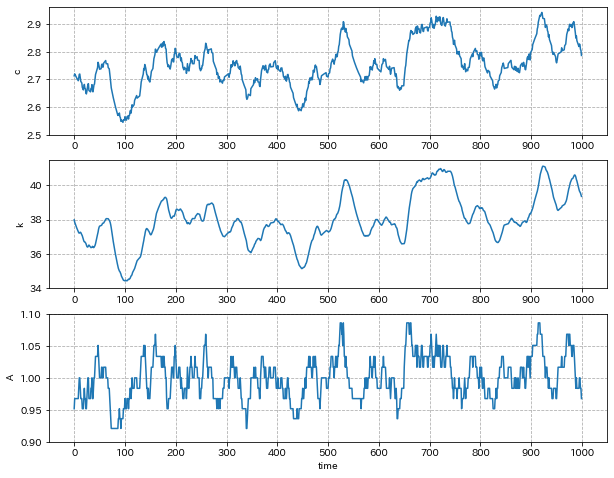

In [10]:
fig, ax = plt.subplots(3,1,figsize=(10,8))
ax[0].plot(cvec)
ax[1].plot(kvec[0:T])
ax[2].plot(np.exp(m.zgrid[ivec[0:T]]))

ax[0].set(ylabel="c",xticks=np.arange(0,1100,100),yticks=[2.5,2.6,2.7,2.8,2.9])
ax[1].set(ylabel="k",xticks=np.arange(0,1100,100),yticks=[34,36,38,40])
ax[2].set(xlabel="time",xticks=np.arange(0,1100,100),ylabel="A",yticks=[0.9,0.95,1,1.05,1.1])

for i in range(3):
    ax[i].grid(ls="--")

#plt.savefig("TI_stochsim.pdf")
plt.show()


In [11]:
# 政策関数を図示する(main_ti_stoch_result.m)
pfcn = np.zeros((m.nk,m.nz))
for j in range(m.nz):
    pfcn[:,j] = np.exp(zgrid[j])*m.kgrid**m.alpha + (1-m.delta)*m.kgrid - cfcn0[:,j];

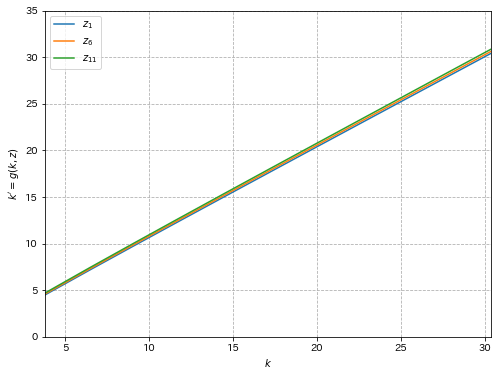

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(m.kgrid,pfcn[:,0],label=r"$z_{1}$")
ax.plot(m.kgrid,pfcn[:,5],label=r"$z_{6}$")
ax.plot(m.kgrid,pfcn[:,10],label=r"$z_{11}$")
ax.set(xlabel=r"$k$",ylabel=r"$k'=g(k,z)$",xlim=(m.kgrid[0],m.kgrid[10]),ylim=(0.0,35.0))
ax.legend()
ax.grid(ls="--")
plt.show()